In [1]:
import scanpy as sc
import multimil as mtm
import anndata as ad
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import scvi
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, f1_score, confusion_matrix
import scipy.stats as st

sc.set_figure_params(dpi=100, frameon=False, facecolor=None, transparent=True)

[rank: 0] Global seed set to 0
/home/icb/zihe.zheng/miniconda3/envs/multimil2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

## preprocess for prediction

In [4]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/seaad_rosmap_integrated.h5ad')
adata

AnnData object with n_obs × n_vars = 4171637 × 7000
    obs: 'sample_id', 'Neurotypical reference', 'Donor_ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mon

In [5]:
adata.obs['APOE Genotype'].unique()

['3/3', '2/3', '3/4', '4/4', '2/2', '2/4', 'nan']
Categories (7, object): ['2/2', '2/3', '2/4', '3/3', '3/4', '4/4', 'nan']

In [6]:
adata.obs['apoe_genotype'].unique()

['nan', '33.0', '34.0', '23.0', '24.0', '44.0', '22.0']
Categories (7, object): ['22.0', '23.0', '24.0', '33.0', '34.0', '44.0', 'nan']

In [7]:
def get_apoe_label(row):
    val = row['APOE Genotype'] if row['APOE Genotype'] != 'nan' else row['apoe_genotype']
    if val == 'nan' or pd.isna(val):
        return np.nan
    count = str(val).count('4')
    return ['0', '1', '2'][count]

adata.obs['apoe_label'] = adata.obs.apply(get_apoe_label, axis=1)


In [8]:
adata.obs['apoe_label'].value_counts()

apoe_label
0    3011052
1     987585
2     171338
Name: count, dtype: int64

In [9]:
adata.obs[['APOE Genotype', 'apoe_genotype', 'apoe_label']]

APOE Genotype apoe_genotype  \
AAACAGCCAAACATAG-L8XR_210916_02_B11-1131607954           3/3           nan   
AAACAGCCAAACTGCC-L8XR_210722_01_H07-1122543705           3/3           nan   
AAACAGCCAAAGCTCC-L8XR_211007_02_C04-1135704089           2/3           nan   
AAACAGCCAAATATCC-L8XR_210729_01_D09-1124629224           3/3           nan   
AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169           3/4           nan   
...                                                      ...           ...   
1649660                                                  nan          33.0   
1649664                                                  nan          23.0   
1649668                                                  nan          23.0   
1649669                                                  nan          33.0   
1649671                                                  nan          34.0   

                                               apoe_label  
AAACAGCCAAACATAG-L8XR_210916_02_B11-1131607954          0  
AAACAGCCAAACTGCC-L8XR_210722_01_H07-1122543705          0  
AAACAGCCAAAGCTCC-L8XR_211007_02_C04-1135704089          0  
AAACAGCCAAATATCC-L8XR_210729_01_D09-1124629224          0  
AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169          1  
...                                                   ...  
1649660                                                 0  
1649664                                                 0  
1649668                                                 0  
1649669                                                 0  
1649671                                                 1  

[4171637 rows x 3 columns]

In [11]:
adata.obs['Overall AD neuropathological Change'].value_counts()

Overall AD neuropathological Change
nan             1625707
High            1145596
Intermediate     690278
Low              388224
Not AD           321832
Name: count, dtype: int64

In [15]:
adata.obs['ceradsc'].value_counts()

ceradsc
nan    2549887
2.0     573601
1.0     476238
4.0     392016
3.0     179895
Name: count, dtype: int64

In [24]:
adata.obs['AD'] = np.where(
    (adata.obs['ceradsc'].isin(['3.0', '4.0'])) | (adata.obs['Overall AD neuropathological Change'].isin(['Not AD'])),
    'healthy',  # Value if condition is True
    'AD'  # Value if condition is False, adjust this as necessary
)

In [25]:
adata.obs[['ceradsc', 'Overall AD neuropathological Change', 'AD']]

ceradsc  \
AAACAGCCAAACATAG-L8XR_210916_02_B11-1131607954     nan   
AAACAGCCAAACTGCC-L8XR_210722_01_H07-1122543705     nan   
AAACAGCCAAAGCTCC-L8XR_211007_02_C04-1135704089     nan   
AAACAGCCAAATATCC-L8XR_210729_01_D09-1124629224     nan   
AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169     nan   
...                                                ...   
1649660                                            2.0   
1649664                                            1.0   
1649668                                            1.0   
1649669                                            2.0   
1649671                                            1.0   

                                               Overall AD neuropathological Change  \
AAACAGCCAAACATAG-L8XR_210916_02_B11-1131607954                              Not AD   
AAACAGCCAAACTGCC-L8XR_210722_01_H07-1122543705                        Intermediate   
AAACAGCCAAAGCTCC-L8XR_211007_02_C04-1135704089                        Intermediate   
AAACAGCCAAATATCC-L8XR_210729_01_D09-1124629224                                High   
AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169                                High   
...                                                                            ...   
1649660                                                                        nan   
1649664                                                                        nan   
1649668                                                                        nan   
1649669                                                                        nan   
1649671                                                                        nan   

                                                     AD  
AAACAGCCAAACATAG-L8XR_210916_02_B11-1131607954  healthy  
AAACAGCCAAACTGCC-L8XR_210722_01_H07-1122543705       AD  
AAACAGCCAAAGCTCC-L8XR_211007_02_C04-1135704089       AD  
AAACAGCCAAATATCC-L8XR_210729_01_D09-1124629224       AD  
AAACAGCCAACAACAA-L8XR_210902_02_B08-1131257169       AD  
...                                                 ...  
1649660                                              AD  
1649664                                              AD  
1649668                                              AD  
1649669                                              AD  
1649671                                              AD  

[4171637 rows x 3 columns]

In [26]:
sc.pp.neighbors(adata, use_rep="X_multigrate")
sc.tl.umap(adata)

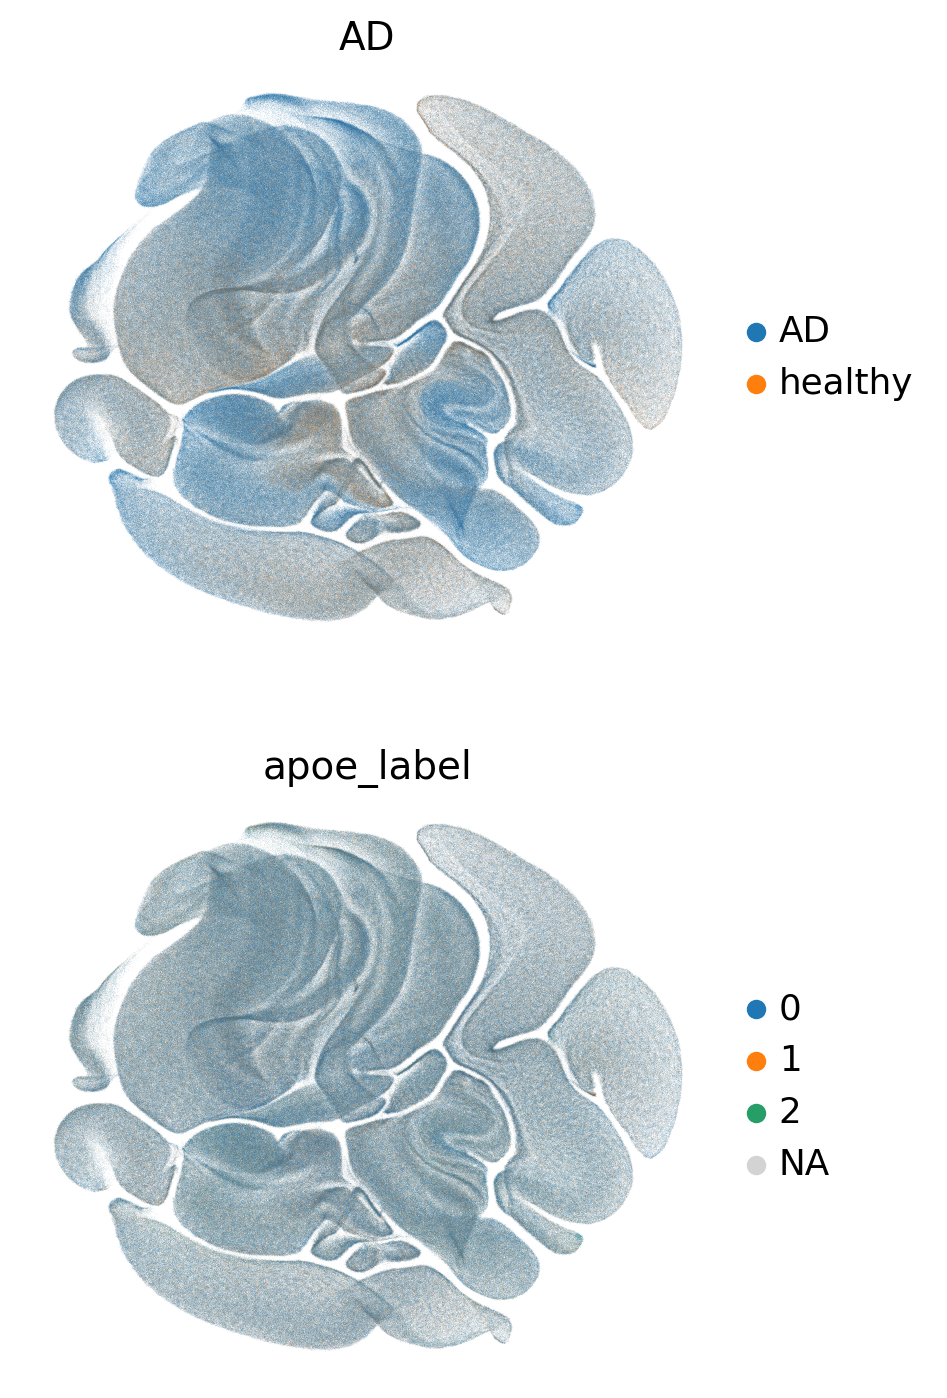

In [27]:
sc.pl.umap(adata, color = ['AD', 'apoe_label'], ncols = 1)

In [37]:
max(list(adata.obs.Donor_ID.value_counts()))

50582

In [13]:
# align cell type labels
subclass_to_broad = {
    'L5 IT': 'Excitatory',
    'L6 IT': 'Excitatory',
    'Pvalb': 'Inhibitory',
    'Microglia-PVM': 'Microglia',
    'Astrocyte': 'Astrocytes',
    'L4 IT': 'Excitatory',
    'L2/3 IT': 'Excitatory',
    'L5/6 NP': 'Excitatory',
    'Sst': 'Inhibitory',
    'Vip': 'Inhibitory',
    'L6 IT Car3': 'Excitatory',
    'Lamp5': 'Inhibitory',
    'Oligodendrocyte': 'Oligodendrocytes',
    'Lamp5 Lhx6': 'Inhibitory',
    'L6 CT': 'Excitatory',
    'Chandelier': 'Inhibitory',
    'L6b': 'Excitatory',
    'OPC': 'OPCs',
    'Sncg': 'Inhibitory',
    'Endothelial': 'Endothelial',
    'Pax6': 'Inhibitory',  
    'VLMC': 'Endothelial',  
    'Sst Chodl': 'Inhibitory',
    'L5 ET': 'Excitatory'
}

# Map to new column
adata.obs['Subclass_aligned'] = adata.obs['Subclass'].map(subclass_to_broad)

In [15]:
adata.obs["subset"] = adata.obs["subset"].cat.rename_categories({"CUX2+": "Excitatory"})

In [16]:
adata.obs['Subclass_aligned'] = adata.obs['Subclass_aligned'].fillna(adata.obs['subset'])

In [16]:
adata.obs[['msex', 'Sex', 'Gender']]

msex   Sex Gender
TATTAGGTCTTGTCTG-L8XR_210812_01_A12-1124987483  nan  Male   Male
GTTAGACTCATCGTTT-L8XR_210812_01_A12-1124987483  nan  Male   Male
AGGAAATCACTGTTCC-L8TX_210430_01_C04-1142430413  nan  Male   Male
GTTAGACTCATTACAG-L8XR_210812_01_A12-1124987483  nan  Male   Male
CTCATTAGTAACCCTA-L8TX_210430_01_C04-1142430413  nan  Male   Male
...                                             ...   ...    ...
238338                                          0.0   nan    nan
238327                                          0.0   nan    nan
238315                                          0.0   nan    nan
238363                                          0.0   nan    nan
1121976                                         0.0   nan    nan

[4169975 rows x 3 columns]

In [ ]:
adata.obs['Sex']

In [ ]:
adata.obs['Gender']

In [20]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/seaad_rosmap_integrated_harmonized.h5ad')

## predictions apoe

In [4]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/seaad_rosmap_integrated_harmonized_apoe.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 4169975 × 16
    obs: 'sample_id', 'Neurotypical reference', 'Donor_ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in month

In [6]:
adata.obs['apoe_label'].value_counts()

apoe_label
0    3011052
1     987585
2     171338
Name: count, dtype: int64

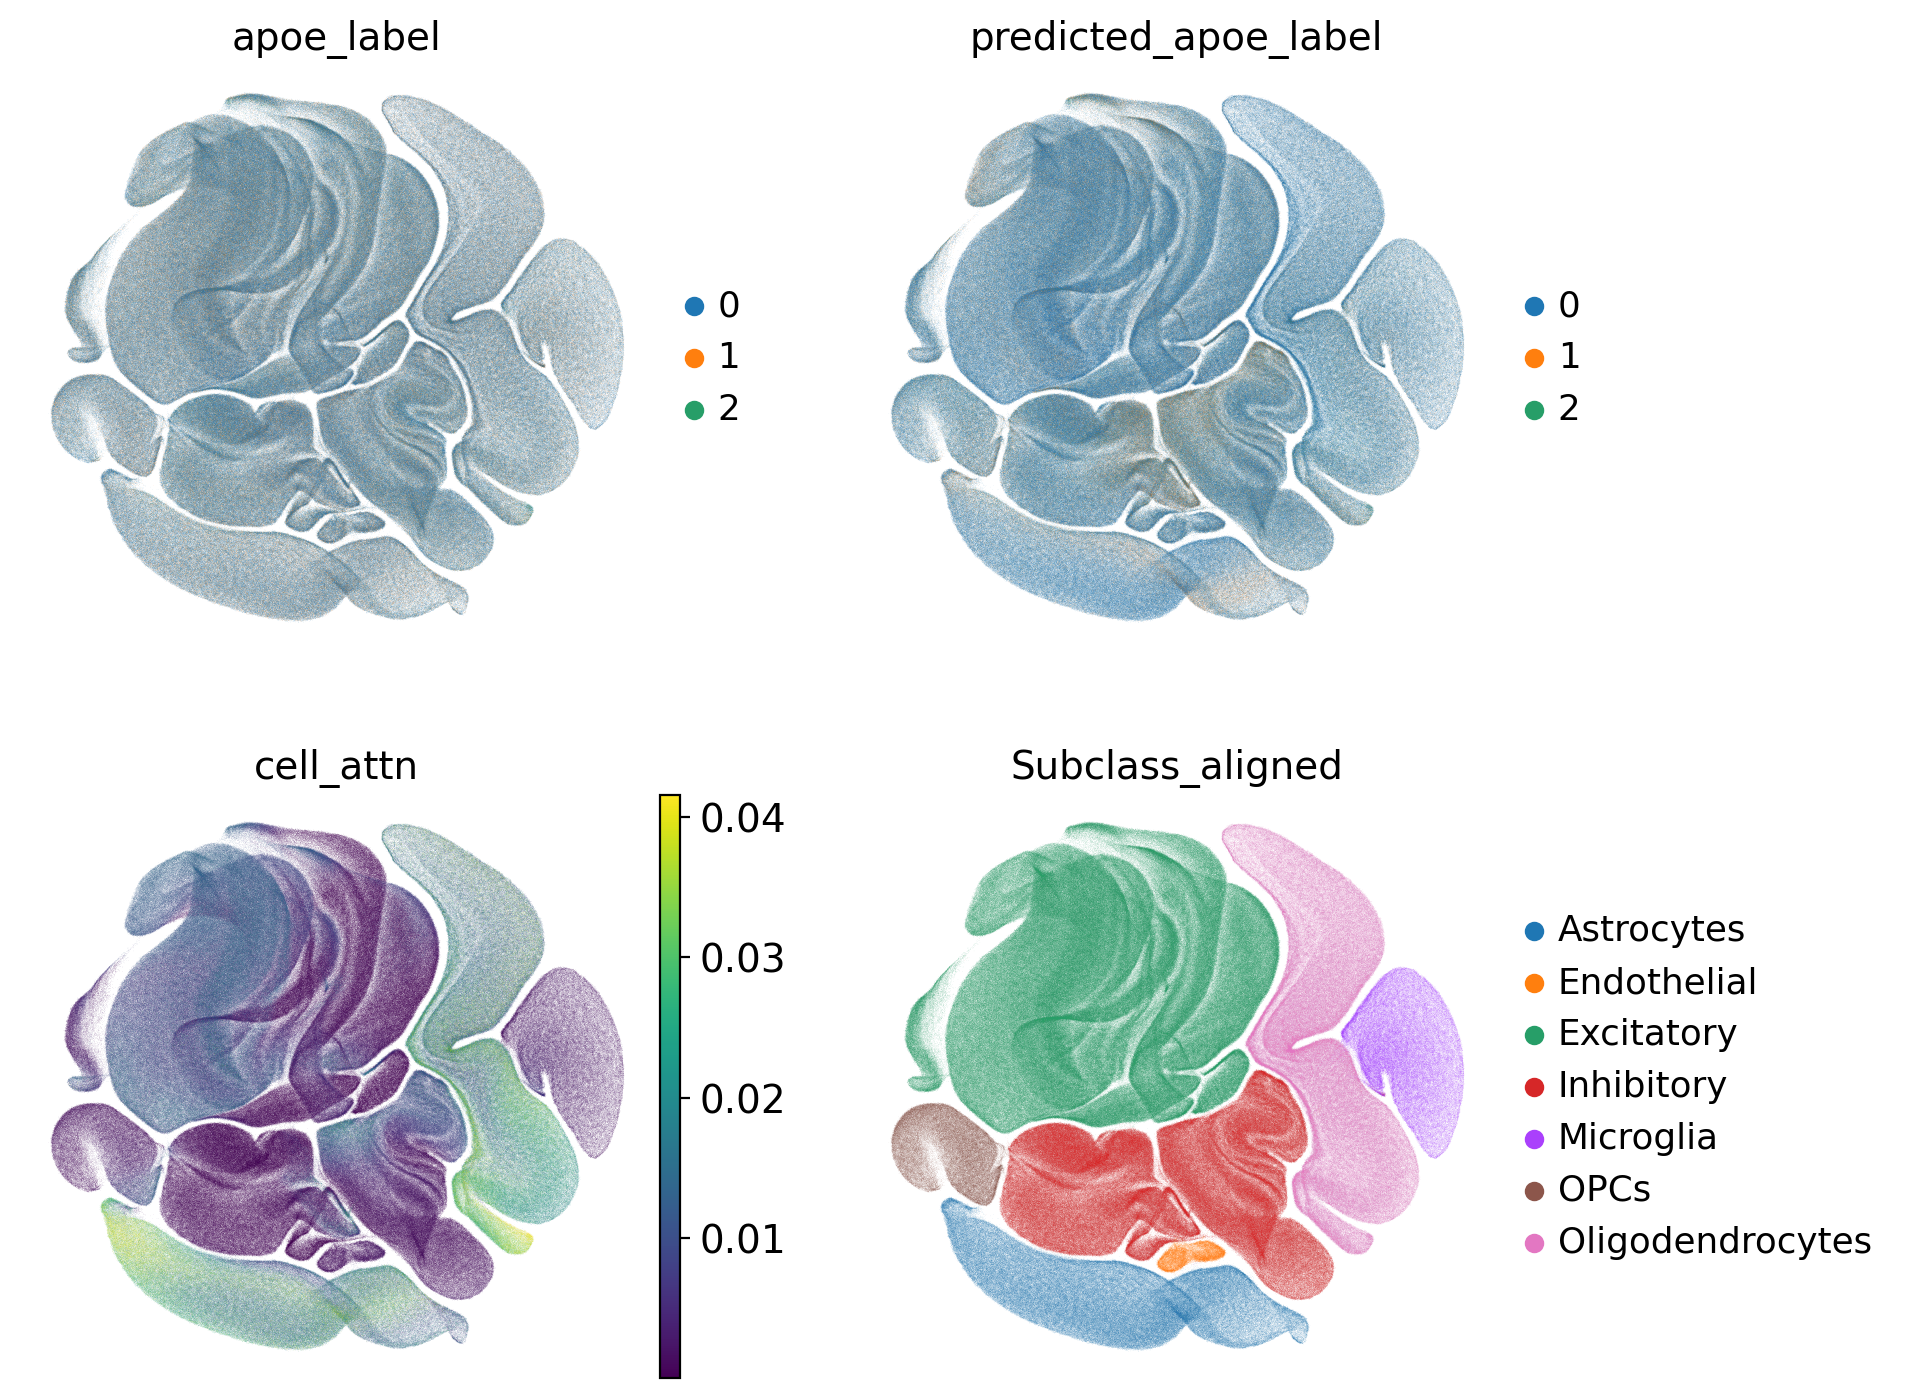

In [7]:
sc.pl.umap(adata, color=["apoe_label", "predicted_apoe_label", "cell_attn", 'Subclass_aligned'], ncols=2, frameon=False, vmax="p99")


## predictions disease

In [8]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/seaad_rosmap_integrated_harmonized_ad.h5ad')

In [9]:
adata.obs['AD'].value_counts()

AD
AD         3277894
healthy     893743
Name: count, dtype: int64

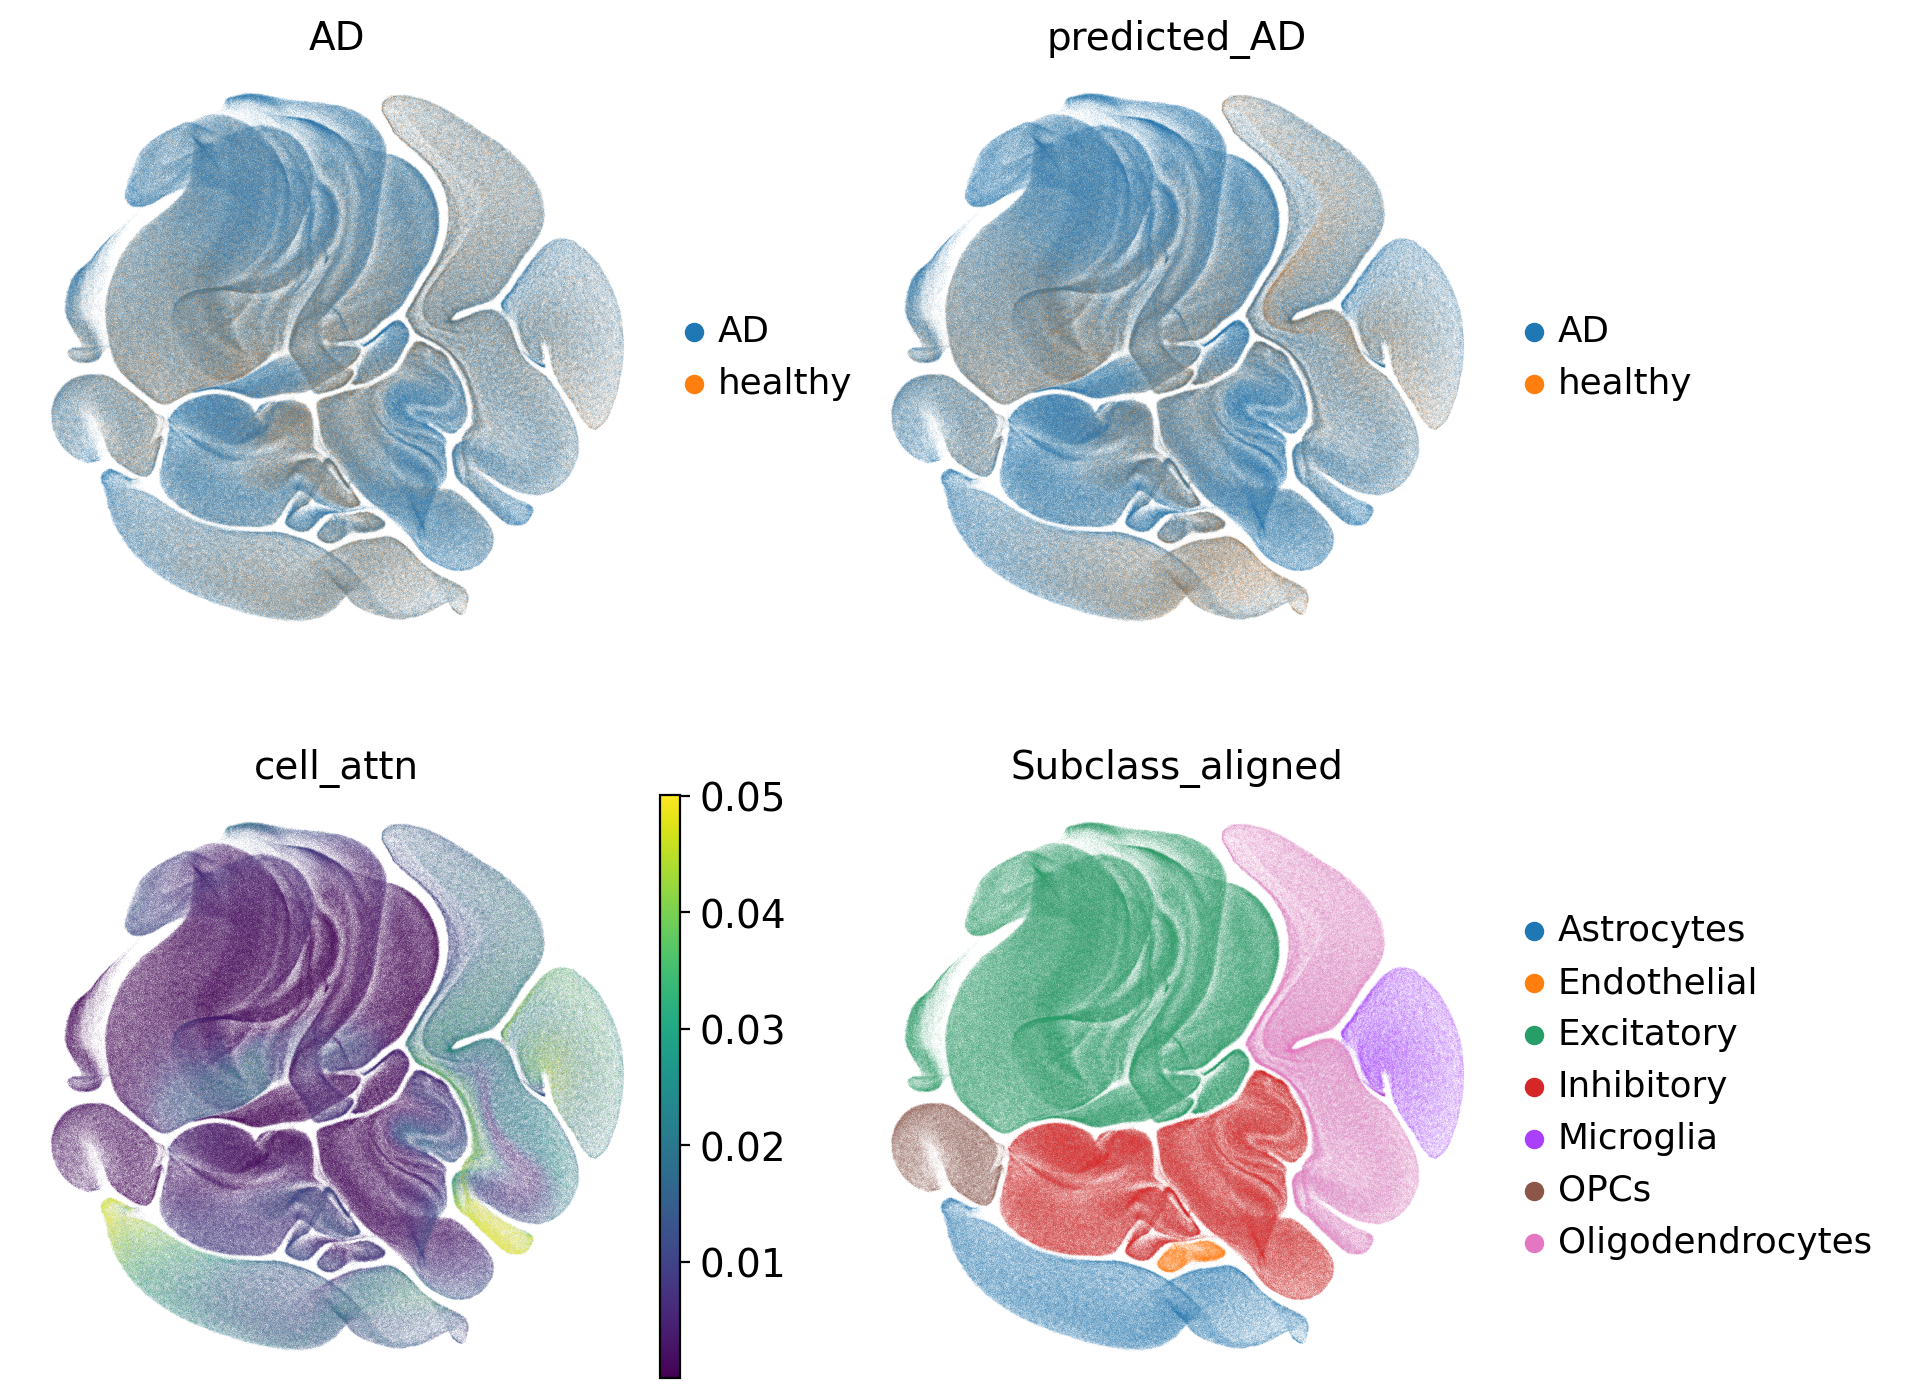

In [10]:
sc.pl.umap(adata, color=["AD", "predicted_AD", "cell_attn", 'Subclass_aligned'], ncols=2, frameon=False, vmax="p99")
